# HANDS ON TROPICAL GEOMETRY

#### Comprehensive guide on how to create 3D-printable models of tropical surfaces, tropical curves, and combinations thereof.

This tutorial requires on `OpenSCAD`, an open source software for creating solid 3D computer-aided design objects. It is freely available for all platforms on [https://openscad.org](https://openscad.org). The notebook only focuses on the creation of tropical 3D models in `OpenSCAD`, as the 3D printing process itself depends significantly on the material and the printer used. Size, thickness, and color are easily adjustable in the `OpenSCAD` file generated by `Polymake`. 

The starting point for creating a 3D-model is one or more polyhedral complexes in $\mathbb{R}^3$. In `polymake`, objects of type `fan::PolyhedralComplex` can always be constructed manually by specifying their `POINTS` and `INPUT_POLYTOPES`. In special cases, which are covered in the upcoming sections, they can also be constructed via some shortcuts.

Given polyhedral complexes in `polymake`, the 3D-model can then be created in four steps:
1. Construct a bounding box in `polymake`. This can be done automatically using our script (which draws a box with a prescribed margin around all vertices) or manually by specifying any bounded polytope (which need not be a cuboid).
2. Export the model from `polymake` to `OpenSCAD` using our script.
3. Adjust the thicknesses in `OpenSCAD`.
4. Export the model from `OpenSCAD` to any 3D-printable file format.

In the following sections, we will specifically discuss the cases of
1. a single tropical surface,
2. a single tropical curve,
3. a tropical surface containing a tropical curve.

The methods used can however be combined to cover arbitrary arrangements of surfaces and curves.

## 0.Preparation

Before running any of the code below, please load the necessary helper functions and change to application tropical by running the code below

In [1]:
script("files/hands_on_tropical_geometry/3d_printing_helper_functions.pl");
application "tropical";

## I. Modelling Tropical Surfaces

### I.1 Constructing a tropical surface in `polymake`

An easy way to construct a tropical surface in $\mathbb{R}^3$ of type `fan::PolyhedralComplex` in `polymake` is by constructing and converting a `tropical::Hypersurface`.
This can be done by specifying a tropical polynomial as a string.

In [2]:
$f = toTropicalPolynomial("min(1+2*w,1+2*x,1+2*y,1+2*z,w+x,w+y,w+z,x+y,x+z,y+z)");
$tropicalSurfaceTmp = new tropical::Hypersurface<Min>(POLYNOMIAL=>$f);

>Important: Since `polymake` uses homogeneous coordinates, i.e., it identifies polyhedra in $\mathbb{R}^3$ with cones in $\mathbb{R}^4$, tropical polynomials need to be tetravariate and homogeneous instead of trivariate and inhomogeneous.

Alternatively, one can specifying an exponent matrix and a coefficient vector:

In [3]:
$exponentVectors = [[2,0,0,0], [1,1,0,0], [1,0,1,0], [1,0,0,1], [0,1,1,0], [0,1,0,1], [0,0,1,1], [0,2,0,0], [0,0,2,0], [0,0,0,2]];
$coefficients = [1,0,0,0,0,0,0,1,1,1];
$tropicalSurfaceTmp = new Hypersurface<Min>(MONOMIALS=>$exponentVectors, COEFFICIENTS=>$coefficients);

To convert the `tropical::Hypersurface` to `fan::PolyhedralComplex`:

In [4]:
$tropicalSurface = new fan::PolyhedralComplex(
                     VERTICES=>$tropicalSurfaceTmp->VERTICES->minor(All,~[1]),
                     MAXIMAL_POLYTOPES=>$tropicalSurfaceTmp->MAXIMAL_POLYTOPES,
                     INPUT_LINEALITY=>$tropicalSurfaceTmp->LINEALITY_SPACE->minor(All,~[1]));
$tropicalSurface->VISUAL;

<!--
polymake for ren
Fri Feb 25 14:52:59 2022
pcom:tropicalSurface
-->


 
 
 
 pcom:tropicalSurface 
 
 
 
 
 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 
	
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 
 


 
 Display 
 
 
 
 Objects 
 
 
 
 
 
 
 Camera 
 
 
 
 Perspective 
 Orthographic 
 
 
 
 

 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

Click here for additional output 
 
polymake: used package cdd
 cddlib
 Implementation of the double description method of Motzkin et al.
 Copyright by Komei Fukuda.
 http://www-oldurls.inf.ethz.ch/personal/fukudak/cdd_home/

polymake: used package threejs
 Three.js is a lightweight cross-browser JavaScript library/API used to create and display animated 3D computer graphics on a Web browser.
 See http://github.com/mrdoob for the source code.

### I.2 Bounding a tropical surface in `polymake` and exporting it to `OpenSCAD`

Constructing a bounding box can be done using the command `generateBoundingBox`:

In [5]:
$boundingBox = generateBoundingBox($tropicalSurface);

>Note: `generateBoundingBox($tropicalSurface)` draws a box around all vertices of `$tropicalSurface` with a margin of 1, `generateBoundingBox($tropicalSurface,3,4,5)` draw a box around all vertices of `$tropicalSurface` with margins 3, 4, 5 in x-, y-, z-direction respectively.

or by specifying a custom `polytope`, which need not be a cuboid:

In [6]:
$boundingBox = polytope::scale(polytope::cube(3),2);

To construct a bounded polyhedral complex use the command `intersectWithBoundingBox`, which intersects any `fan::PolyhedralComplex` with a `polytope`.

In [7]:
$tropicalSurfaceBounded = intersectWithBoundingBox($tropicalSurface,$boundingBox);
$tropicalSurfaceBounded->VISUAL;

<!--
polymake for ren
Fri Feb 25 14:53:01 2022
pcom:
-->


 
 
 
 pcom: 
 
 
 
 
 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 
	
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 
 


 
 Display 
 
 
 
 Objects 
 
 
 
 
 
 
 Camera 
 
 
 
 Perspective 
 Orthographic 
 
 
 
 

 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

The command `generateSCADFileForSurface` exports the tropical surface to `OpenSCAD`. It requires a bounded polyhedral complex and a filename. If the file already exists, it will be overwritten:

In [8]:
$filename = "foo.scad";
generateSCADFileForSurface($tropicalSurfaceBounded,$filename);

### I.3 Solidifying a polyhedral complex in `OpenSCAD` and exporting it for 3D-printing

To solidify the surface into a three-dimensional model, open the exported file in `OpenSCAD`. Below is a preview of a solidified tropical quadratic surface.
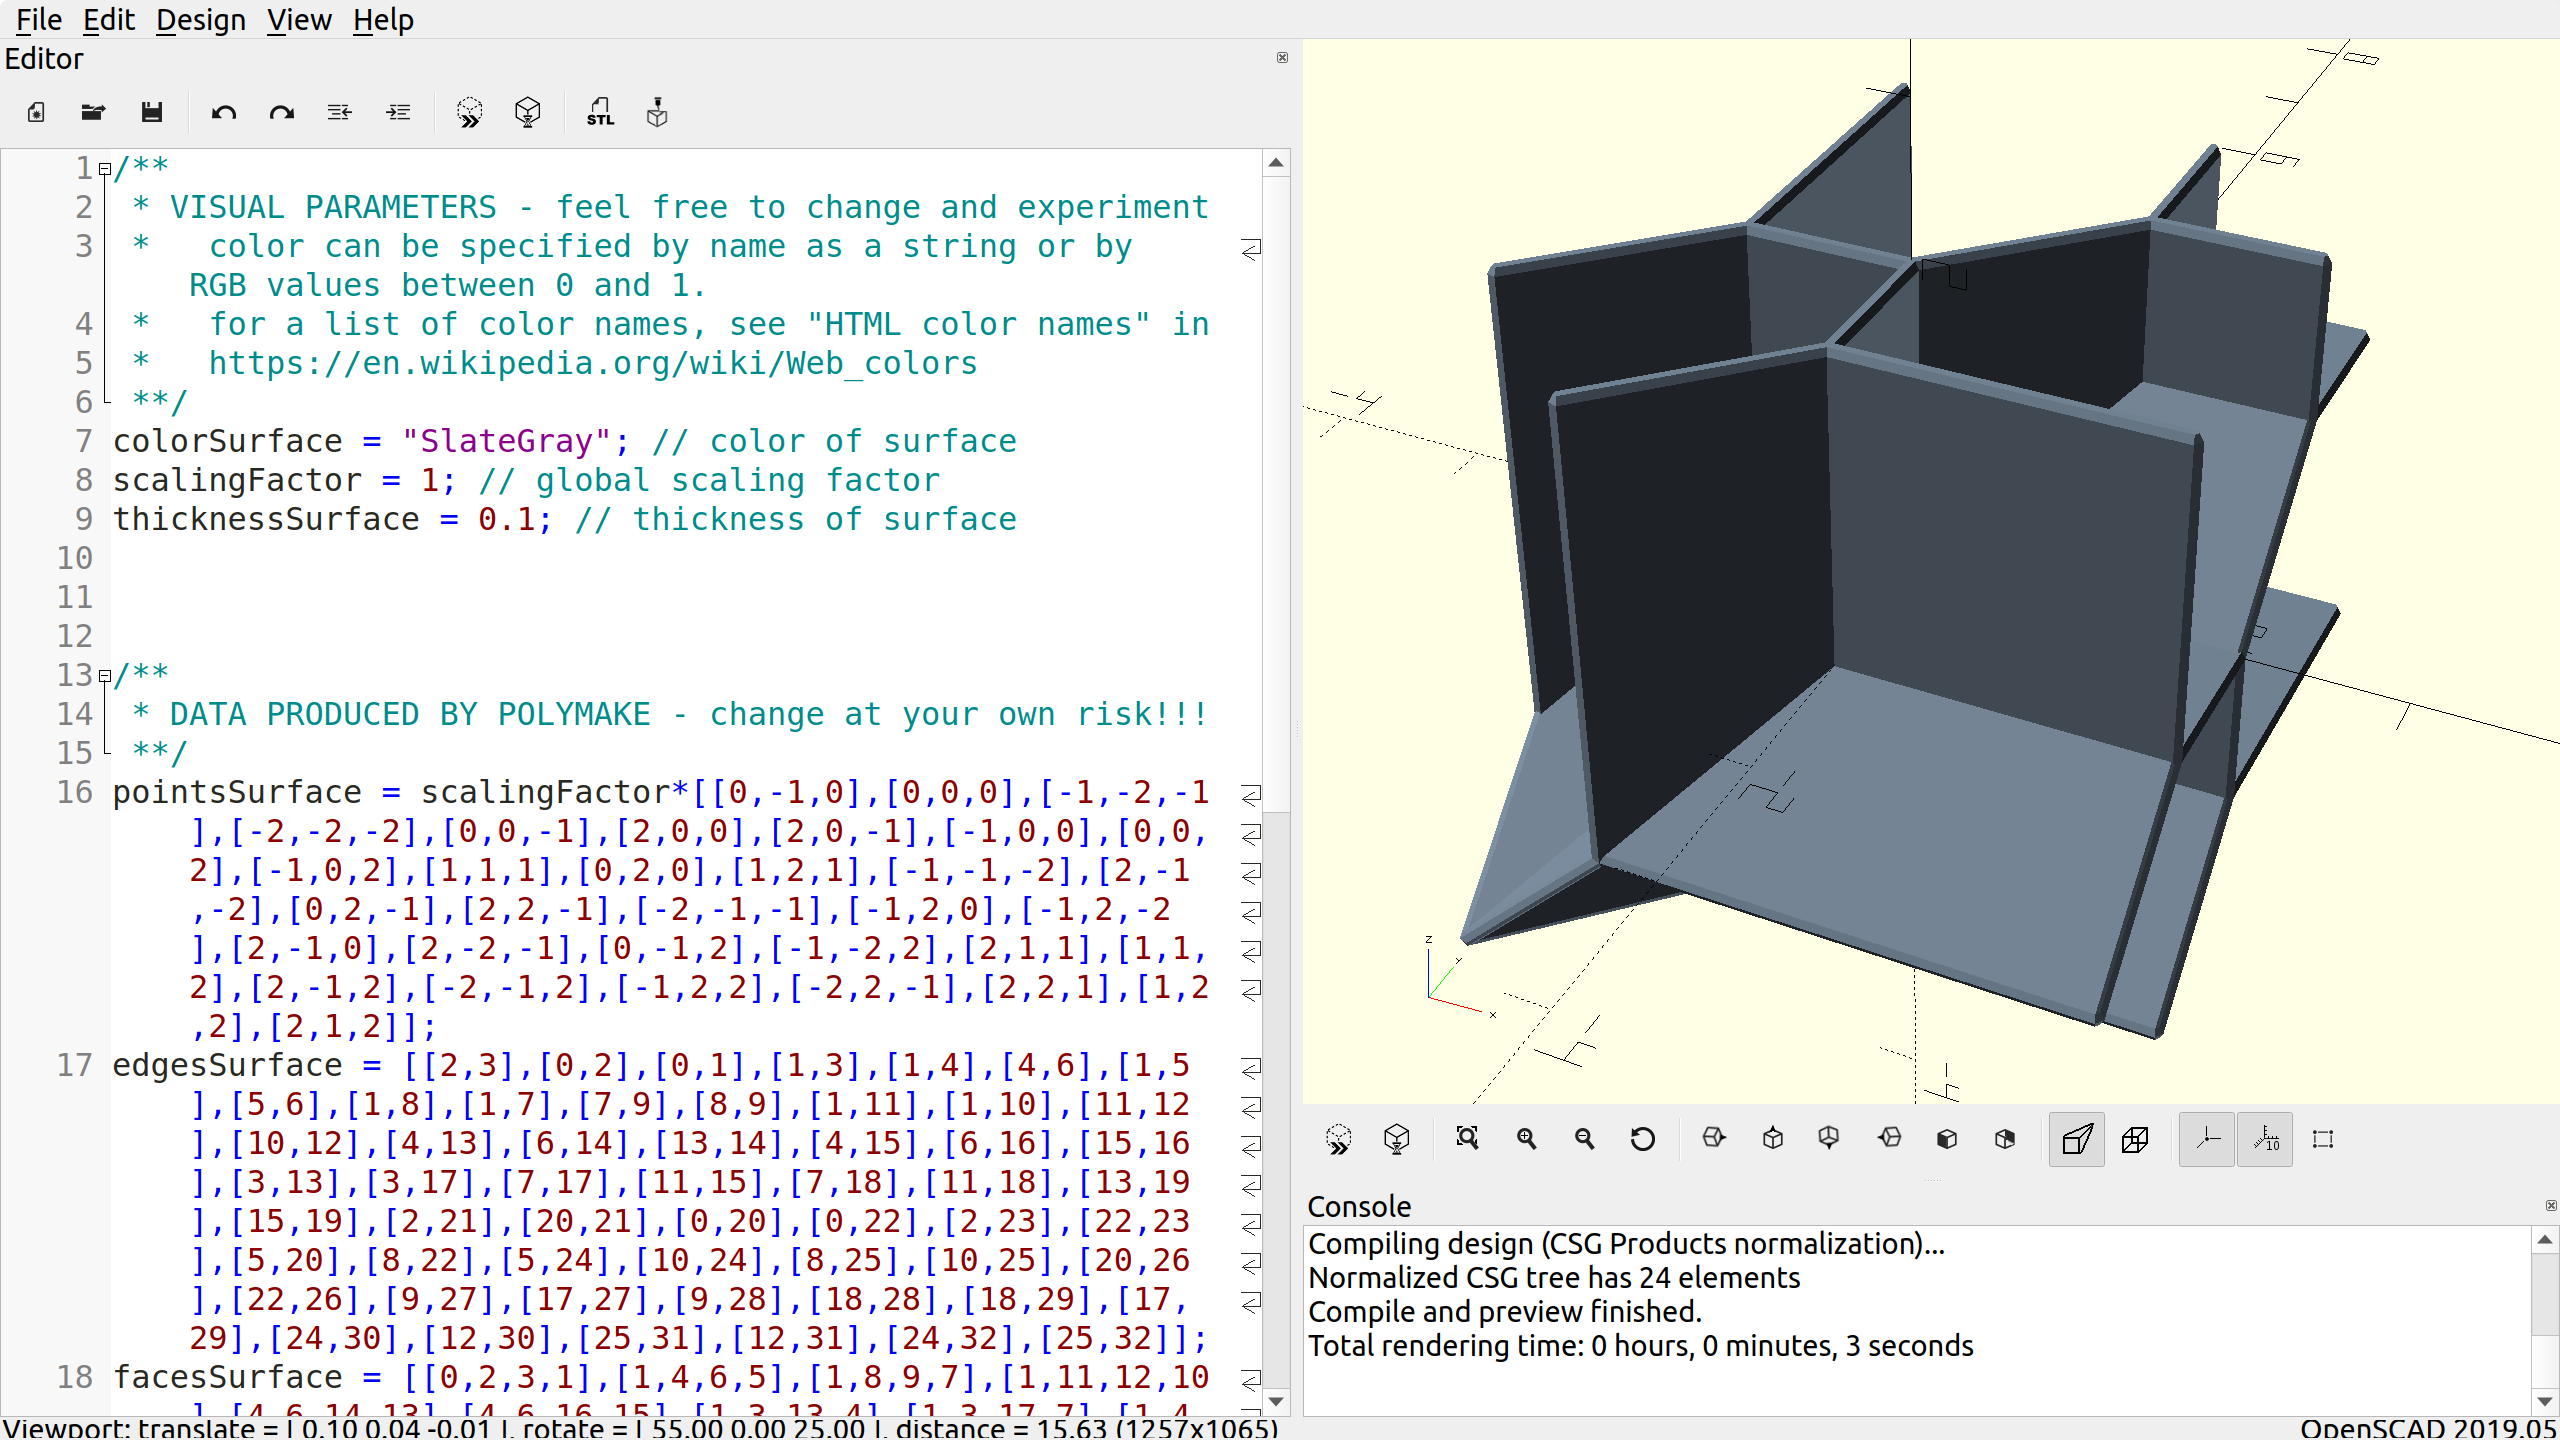

The top of the `OpenSCAD` file contains parameters which control the thickness of the model amongst other things:

```java
colorSurface = "SlateGray"; // color of surface
scalingFactor = 1; // global scaling factor
thicknessSurface = 0.05; // thickness of surface
```

1. `colorSurface` is the color of the surface in the render. It can be specified either by an HTML color name or by RGB value.
2. `scalingFactor` is a factor by which the polyhedral complex is scaled. It can be used to scale the model to a desired size.
3. `thicknessSurface` controls the thickness of the surface. `OpenSCAD` solidifies the surface by replacing every vertex with a ball with specified thickness and taking convex hulls.

>Important: In order to 3D-print the tropical surface, every face needs to have a minimal thickness. As a rule of thumb for printing with PLA, we recommend a minimal thickness of 2mm for a print of size 10cm<sup>3</sup>.

## II. Modelling Tropical Curves

### II.1 Constructing a tropical curve in `polymake`

An easy way to construct a tropical curve in $\mathbb{R}^3$ of type `fan::PolyhedralComplex` in `polymake` is by intersecting two tropical surfaces. Note however that not all tropical curves can be constructed this way.

Below is an example of how to define a tropical sextic curve as an intersection of a tropical quadratic and a cubic surface.

In [9]:
# constructing tropical quadric surface
$mQuadric = [[2,0,0,0], [1,1,0,0], [1,0,1,0], [1,0,0,1],
               [0,1,1,0], [0,1,0,1], [0,0,1,1], [0,2,0,0],
               [0,0,2,0], [0,0,0,2]];
$cQuadric = [1,-1/4,-2/4,-3/4,-3/4,-4/4,-5/4,2/4,0,-2/4];
$TQuadric = new tropical::Hypersurface<Min>(MONOMIALS=>$mQuadric,
                                            COEFFICIENTS=>$cQuadric);

# constructing tropical cubic surface
$mCubic = [[3,0,0,0], [0,3,0,0], [0,0,3,0], [0,0,0,3],
           [1,1,1,0], [1,1,0,1], [1,0,1,1], [0,1,1,1],
           [2,1,0,0], [2,0,1,0], [2,0,0,1], [1,2,0,0],
           [1,0,2,0], [1,0,0,2], [0,2,1,0], [0,2,0,1],
           [0,1,2,0], [0,1,0,2], [0,0,2,1], [0,0,1,2]];
$cCubic = [3,3,3,3,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1];
$TCubic = new tropical::Hypersurface<Min>(MONOMIALS=>$mCubic,
                                          COEFFICIENTS=>$cCubic);

# constructing a tropical sextic curve as the stable intersection
#   of a quadratic and a cubic surface
$tropicalCurveTmp = tropical::intersect($TQuadric,$TCubic);

Click here for additional output 
 
polymake: used package atint
 [[wiki:external_software#a-tint]] is an extension for tropical intersection theory.
 (C) 2011 - 2015 Simon Hampe, simon.hampe@googlemail.com
 See also: https://github.com/simonhampe/atint

>Important: `intersect` is the intersection of tropical cycles, i.e., it tcomputes the so-called stable intersection, not the set-theoretic intersection.

As before, we convert the tropical curve to type `fan::PolyhedralComplex`:

In [10]:
$tropicalCurve = new fan::PolyhedralComplex(
                   VERTICES=>$tropicalCurveTmp->VERTICES->minor(All,~[1]),
                   MAXIMAL_POLYTOPES=>$tropicalCurveTmp->MAXIMAL_POLYTOPES,
                   INPUT_LINEALITY=>$tropicalCurveTmp->LINEALITY_SPACE->minor(All,~[1]));
$tropicalCurve->VISUAL;

<!--
polymake for ren
Fri Feb 25 14:53:05 2022
pcom:tropicalCurve
-->


 
 
 
 pcom:tropicalCurve 
 
 
 
 
 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 
	
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 
 


 
 Display 
 
 
 
 Objects 
 
 
 
 
 
 
 Camera 
 
 
 
 Perspective 
 Orthographic 
 
 
 
 

 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

### II.2 Framing a tropical curve in `polymake` and exporting it to `OpenSCAD`

Constructing a bounding box can be done using the command `generateBoundingBox` as before:

In [11]:
$boundingBox = generateBoundingBox($tropicalCurve);
$tropicalCurveBounded = intersectWithBoundingBox($tropicalCurve,$boundingBox);

For the sake of stability, the tropical curve requires a frame. This is best done using a tropical surface containing it:

In [12]:
$tropicalSurface = new fan::PolyhedralComplex(
                     VERTICES=>$TQuadric->VERTICES->minor(All,~[1]),
                     MAXIMAL_POLYTOPES=>$TQuadric->MAXIMAL_POLYTOPES);
$tropicalSurfaceFrame = intersectWithBoundingBoxForFraming($tropicalSurface,$boundingBox);
compose($tropicalCurveBounded->VISUAL,$tropicalSurfaceFrame->VISUAL); 
#todo: adjust edge thicknesses to distinguish frame from curve

<!--
polymake for ren
Fri Feb 25 14:53:19 2022
pcom:
-->


 
 
 
 pcom: 
 
 
 
 
 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 
	
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 
 


 
 Display 
 
 
 
 Objects 
 
 
 
 
 
 
 Camera 
 
 
 
 Perspective 
 Orthographic 
 
 
 
 

 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

Exporting the frame and the tropical curve to `OpenSCAD` can be done using the command `generateSCADFileForCurve`. It requires two bounded polyhedral complexes and a filename. If the file already exists, it will be overwritten:

In [13]:
$filename = "foo.scad";
generateSCADFileForCurve($tropicalSurfaceFrame,$tropicalCurve,$filename);

### II.3 Solidifying a tropical curve in `OpenSCAD` and exporting it for 3D-printing

To solidify the curve into a three-dimensional model, open the exported file in `OpenSCAD`. Here is the preview of the solidified tropical sextic curve (with frame) constructed above:

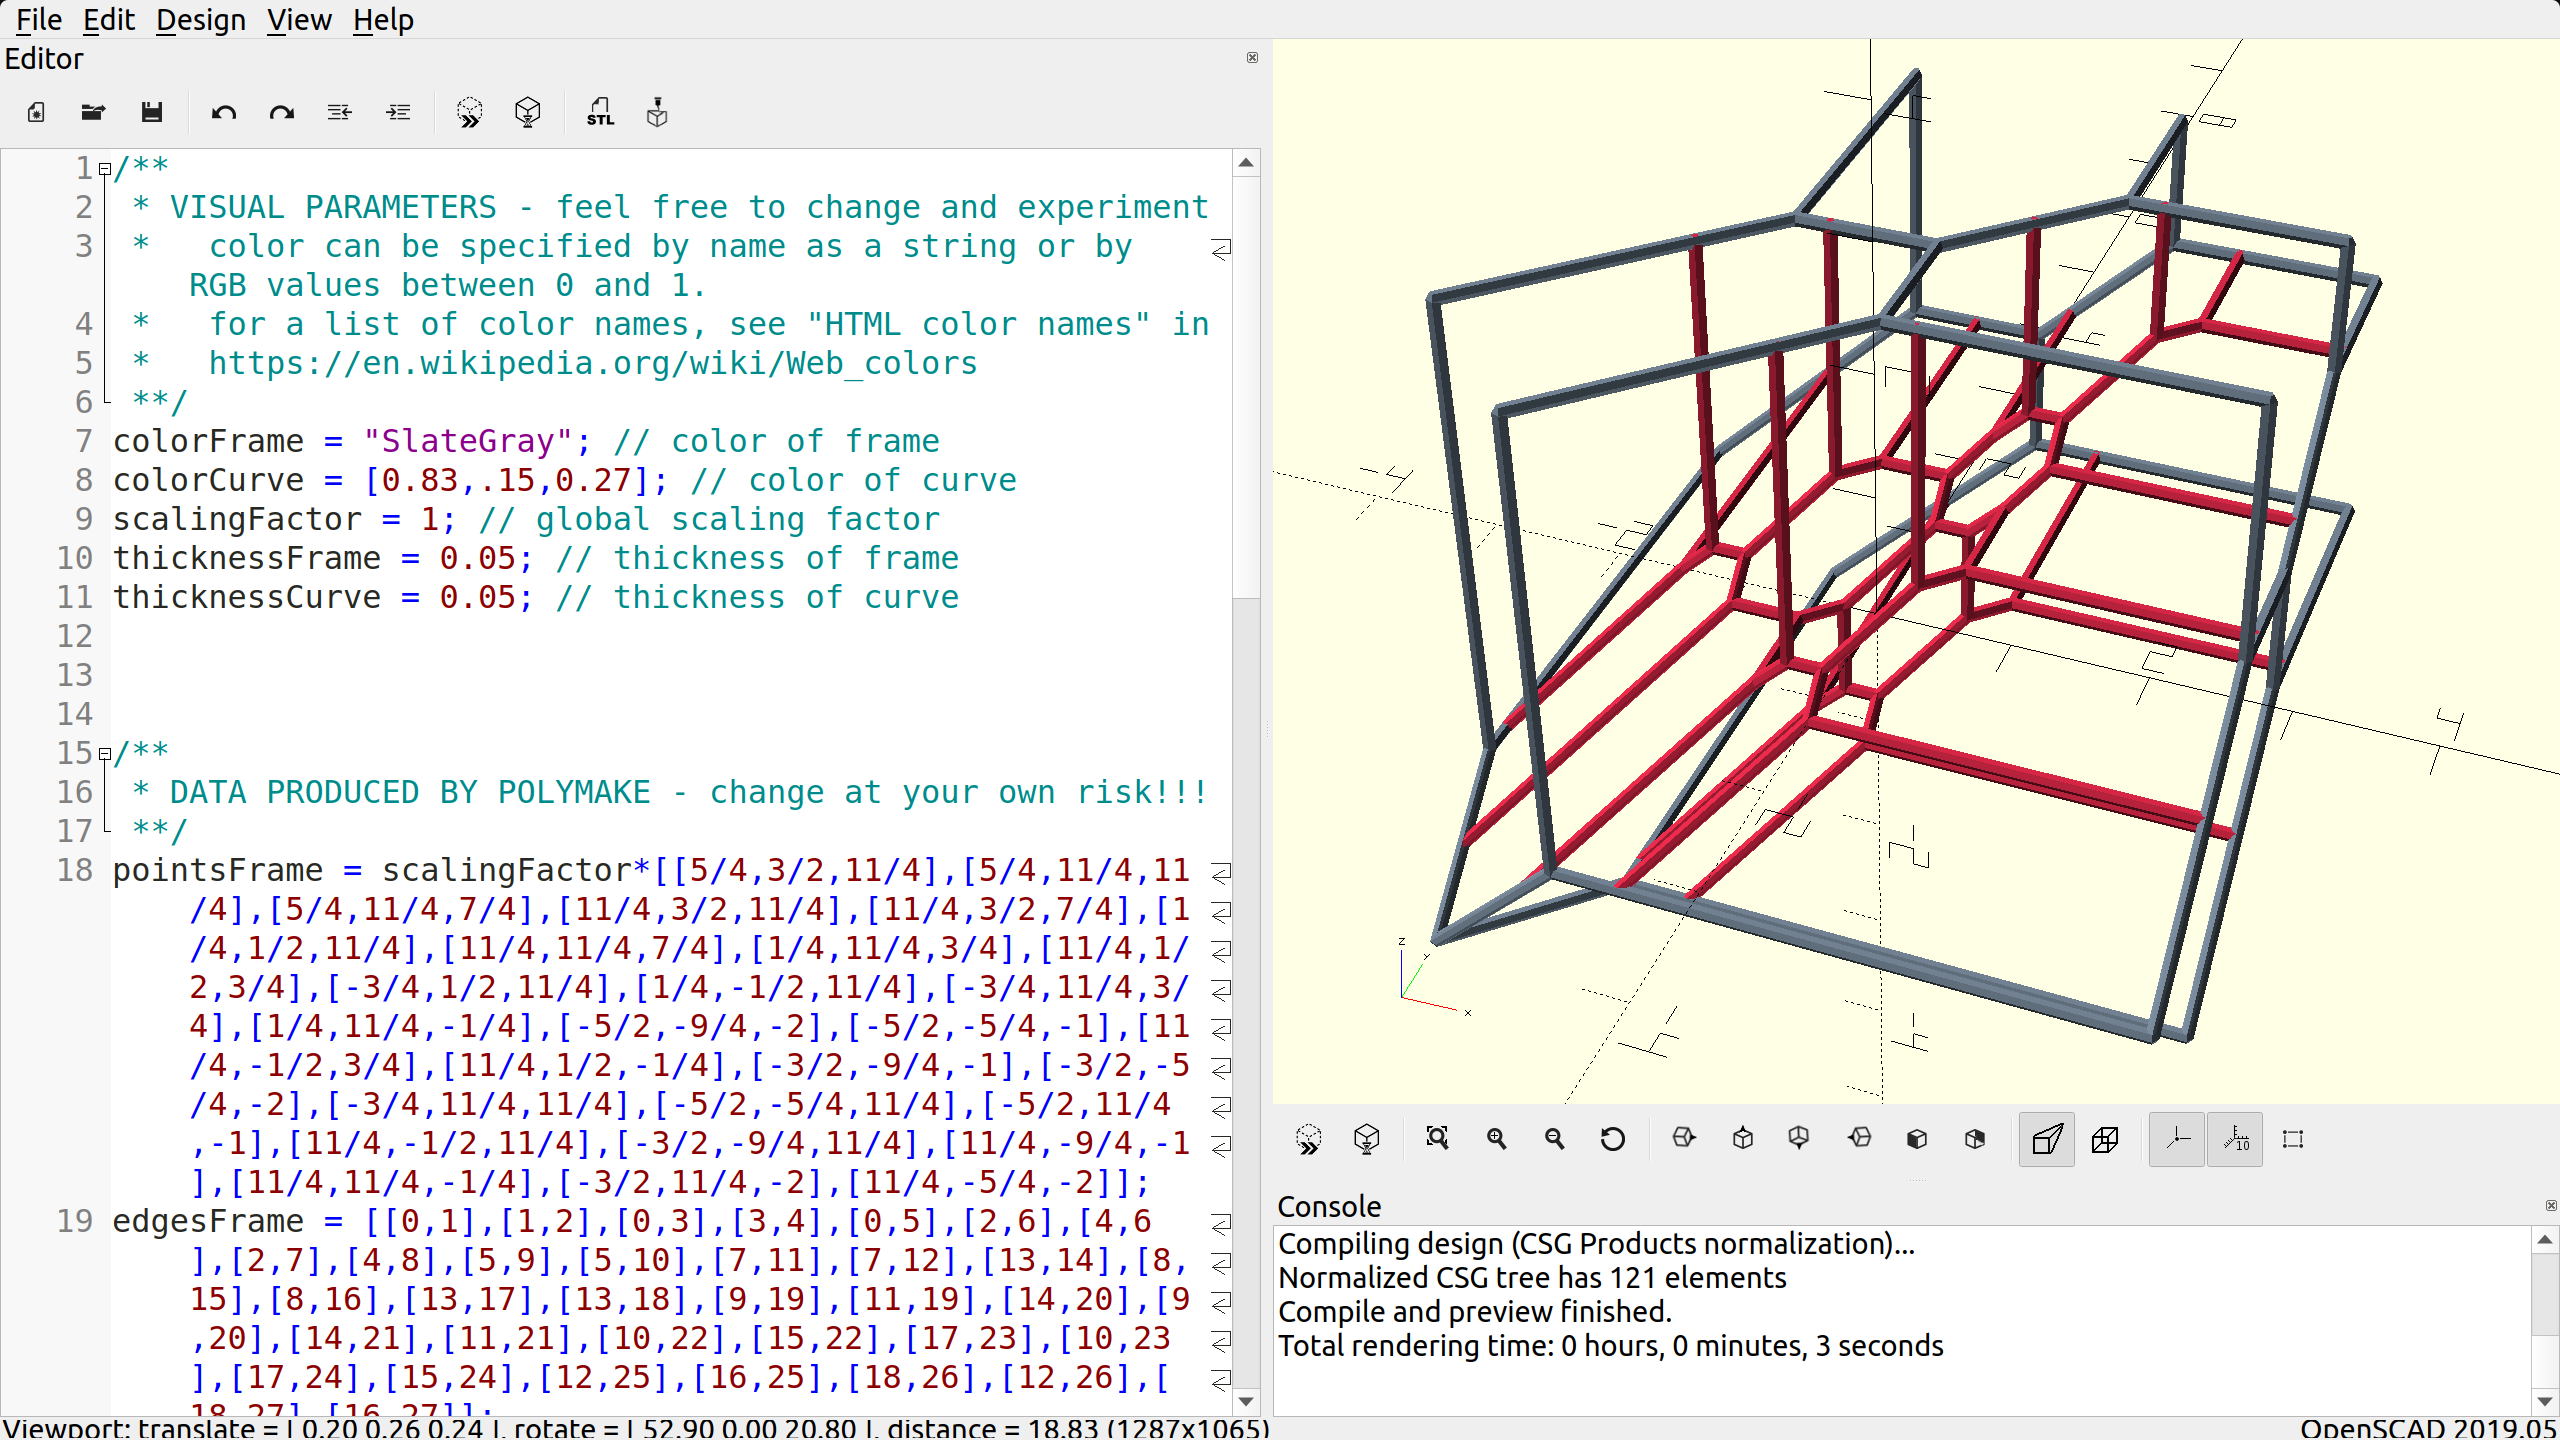

As before, the top of the `OpenSCAD` file contains parameters which control the thickness of the model amongst other things:
```java
colorFrame = "SlateGray"; // color of frame
colorCurve = [0.83,.15,0.27]; // color of curve
scalingFactor = 1; // global scaling factor
thicknessFrame = 0.05; // thickness of frame
thicknessCurve = 0.05; // thickness of curve
```

1. `colorFrame` and `colorCurve` are the colors of the surface in the render. They can be specified either by an HTML color name or by RGB value.
2. `scalingFactor` is a factor by which the polyhedral complex is scaled. It can be used to scale the model to the desired size.
3. `thicknessFrame` and `thicknessCurve` control the thickness of the frame and curve. `OpenSCAD` solidifies both by replacing every vertex with a ball with diameter equal to the specified radius and taking convex hulls.

## III. Modelling Tropical Curves on Tropical Surfaces

### III.1 Constructing a curve and surface in `polymake`

The previous section showed an easy way to construct a tropical curve lying on a tropical surface in `polymake`: start with the surface and construct the curve by intersecting it with another surface. However, as mentioned before, this may not always possible or easy to do. One option that always works is to construct the curve manually by specifying its vertices and edges:

In [14]:
$linearEquation = toTropicalPolynomial("max(y,z,w)",qw(w x y z));
$tropicalSurfaceTmp = new tropical::Hypersurface<Max>(POLYNOMIAL=>$linearEquation);
$tropicalSurface = new fan::PolyhedralComplex(
                     POINTS=>$tropicalSurfaceTmp->VERTICES->minor(All,~[1]),
                     INPUT_POLYTOPES=>$tropicalSurfaceTmp->MAXIMAL_POLYTOPES,
                     INPUT_LINEALITY=>$tropicalSurfaceTmp->LINEALITY_SPACE->minor(All,~[1]));
        
$tropicalCurveVertices = 
   [[1,0,0,0],[1,-8,0,0],[1,-8,-6,0],[1,12,0,0],[0,0,-1,0],[1,-6,-6,0],[1,-11,-3,0],
    [1,-11,-6,0],[0,-1,0,0],[1,-12,-7,0],[1,4,0,-2],[1,10,0,-2],[1,8,0,-6],[0,0,0,-1],
    [0,1,1,1],[1,-4,6,6],[1,-4,5,5],[1,-3,5,5],[1,-5,4,4],[1,-3,3,3],[1,-5,3,3]];
$tropicalCurveEdges = 
  [[3,4],[0,5],[2,5],[4,5],[1,6],[6,7],[6,8],[2,7],[7,9],[8,9],[4,9],[10,11],[3,11],[11,12],
   [0,10],[10,12],[12,13],[1,13],[14,15],[8,15],[15,16],[14,17],[16,17],[16,18],[17,19],[8,18],
   [18,20],[0,19],[19,20],[1,20],[3,14]];
$tropicalCurve = new fan::PolyhedralComplex(
                   POINTS=>$tropicalCurveVertices,
                   INPUT_POLYTOPES=>$tropicalCurveEdges);

(for a preview of the constructed tropical plane with a tropical quartic curve see below)

### III.2 Bounding a tropical surface in `polymake` and exporting it to `OpenSCAD`

Constructing a bounding box is easiest done using the command `generateBoundingBox` as before:

In [15]:
$boundingBox = generateBoundingBox($tropicalCurve);
$tropicalSurfaceBounded = intersectWithBoundingBox($tropicalSurface,$boundingBox);
$tropicalCurveBounded = intersectWithBoundingBox($tropicalCurve,$boundingBox);
compose($tropicalSurfaceBounded->VISUAL,$tropicalCurveBounded->VISUAL);

<!--
polymake for ren
Fri Feb 25 14:53:24 2022
pcom:
-->


 
 
 
 pcom: 
 
 
 
 
 
 
 Explode 
 
 Automatic explosion 
 Exploding speed 
 
 
	
 
 Transparency 
 
 
 
 
 Rotation 
 
 x-axis 
 y-axis 
 z-axis 
 Reset 
 

 Rotation speed 
 
 


 
 Display 
 
 
 
 Objects 
 
 
 
 
 
 
 Camera 
 
 
 
 Perspective 
 Orthographic 
 
 
 
 

 
 SVG 
 
 
 Download 
 New tab 
 
 Screenshot 
 
 

 <!-- end of settings -->

Exporting the tropical surface and curve to `OpenSCAD` can be done using the command `generateSCADFileForSurfaceAndCurve`. It requires two bounded polyhedral complexes and a filename. If the file already exists, it will be overwritten:

In [16]:
$filename = "foo.scad";
generateSCADFileForSurfaceAndCurve($tropicalSurfaceBounded,$tropicalCurveBounded,$filename);

### III.3 Solidifying a tropical surface with curve in `OpenSCAD` and exporting it for 3D-printing

To solidify the surface and curve into a three-dimensional model, open the exported file in `OpenSCAD`. Here is a preview of the solidified tropical plane with a tropical quartic curve constructed above:

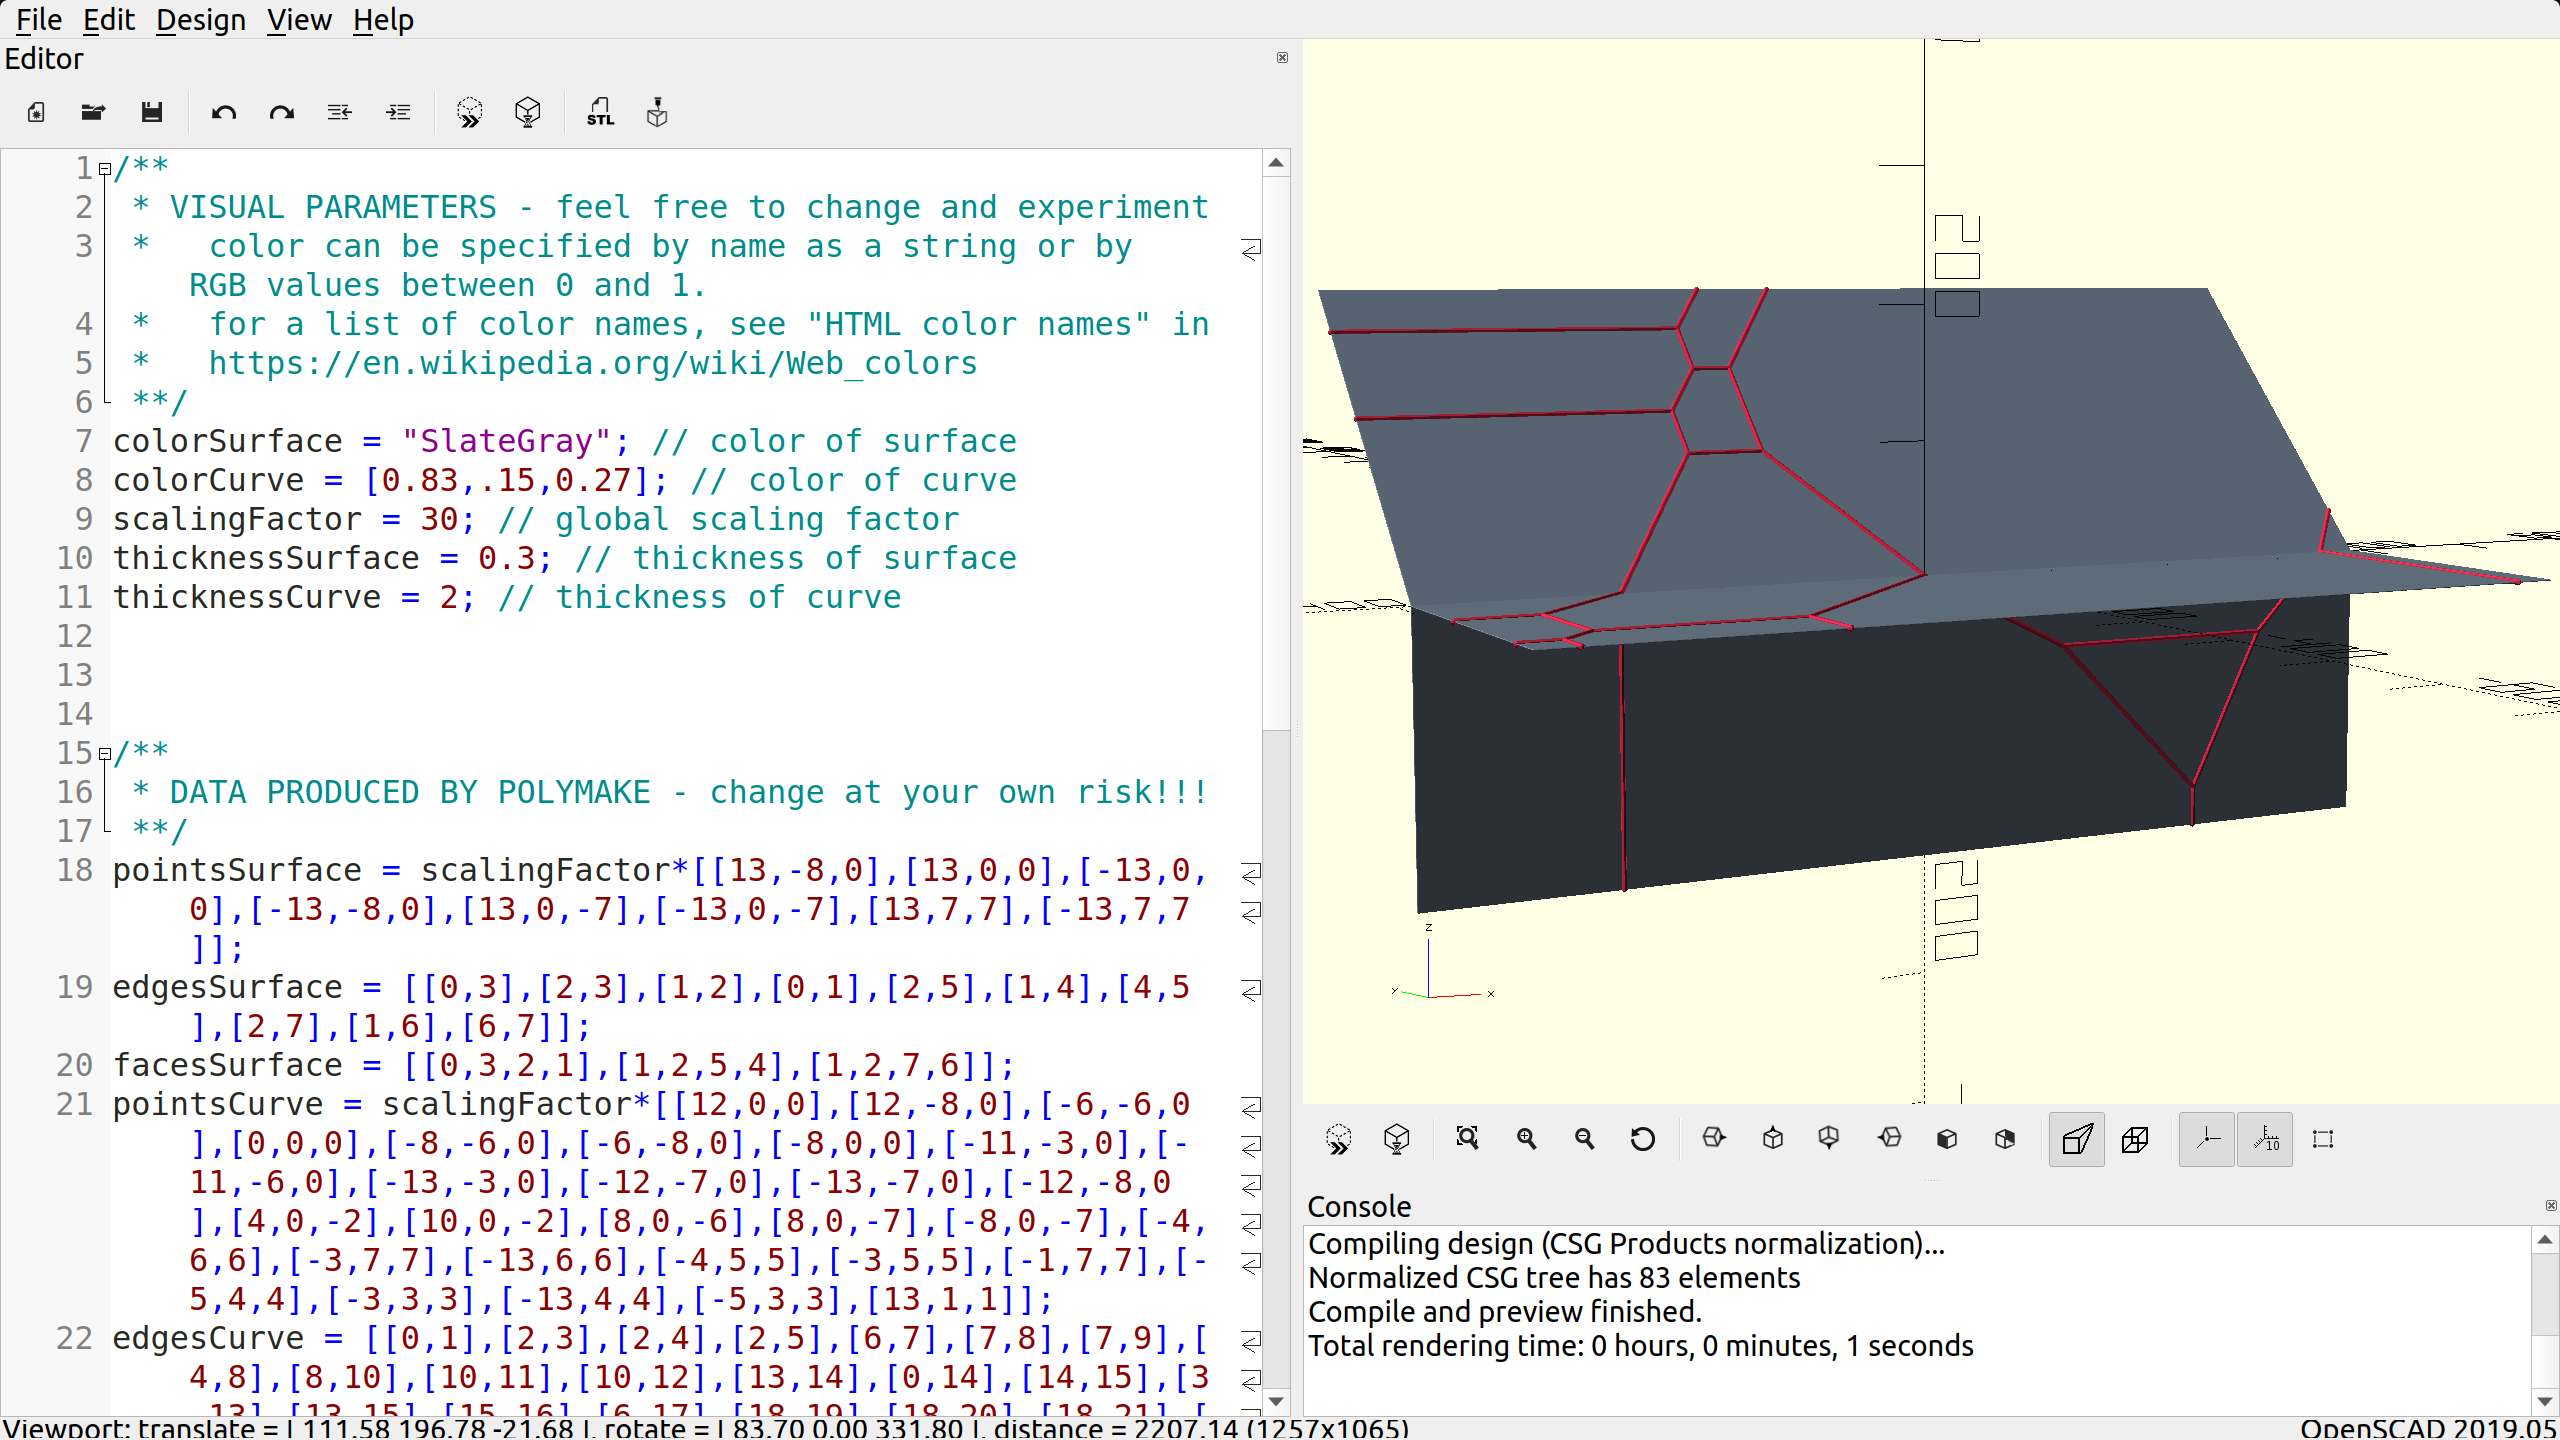

The top of the `OpenSCAD` file contains parameters which control the thickness of the model amongst other things:

```java
colorSurface = "SlateGray"; // color of surface
colorCurve = [0.83,.15,0.27]; // color of curve
scalingFactor = 1; // global scaling factor
thicknessSurface = 0.01; // thickness of surface
thicknessCurve = 0.1; // thickness of curve
```

1. `colorSurface` and `colorCurve` are the colors of the surface and curve in the render. It can be specified either by an HTML color name or by RGB value.
2. `scalingFactor` is a factor by which the polyhedral complex is scaled. It can be used to scale the model to the desired size.
3. `thicknessSurface` and `thicknessCurve` control the thickness of the surface and curve. `OpenSCAD` solidifies the surface by replacing every vertex with a ball with diameter equal to the specified radius and taking convex hulls.

## IV. Printing tropical models using `Prusa`

To 3D-print our models using `Prusa`, we suggest exporting them to `3mf`. The advantage of the `3mf` file format is that it may contain multiple objects. The relative positions of the object is stored, so that - once loaded into `PrusaSlicer` - they are aligned as intended and we could assign them differently colored materials. The export of a single `3mf` file containing multiple objects can be done with [`Colorscad`](https://github.com/jschobben/colorscad).